Source Code from https://github.com/mikesmales/Udacity-ML-Capstone/blob/master/Notebooks/

Earlier, we were using a CNN training model using 40 MFCC bins and training it for 200 epochs on 64 batch size. And we have an accuracy of 86.3%. Now we will see if we can improve the accuracy. One of the approach is to increase the MFCC bin size from 40 to 60 to extract more features from the audio file. And due to the increase in features, we needed more epochs to train the model.

In [1]:
# Load various imports 
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

n_mfcc = 60
num_epochs = 200
num_batch_size = 64
seed = 29
np.random.seed(seed)

We created a function to extract the MFCC features of each wave file in our dataset (data.pk created from previous model). We started off with extracting 40 MFCC "bins" from the audio file. We have to perform a mean function on every bin to create a 1-dimension array to train our model.

In [2]:

def extract_audio_features_from(audio):
   
    try:
        sample_rate=22050
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(e)
        return None 
     
    return mfccsscaled

import pickle
f=open('./data.pk','rb')
data = pickle.load(f)

In [3]:
data['mfcc']=data['wave'].apply(extract_audio_features_from)

Childen Playing


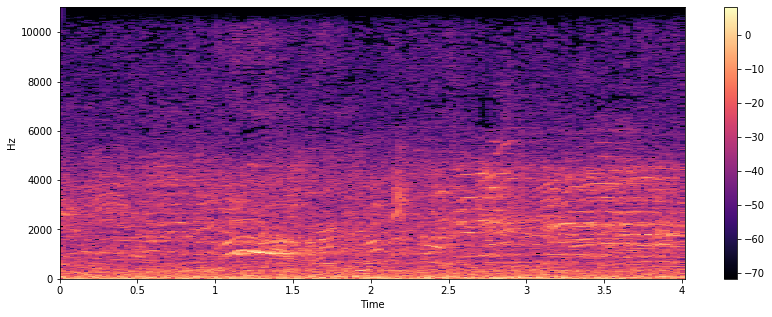

Gun Shot


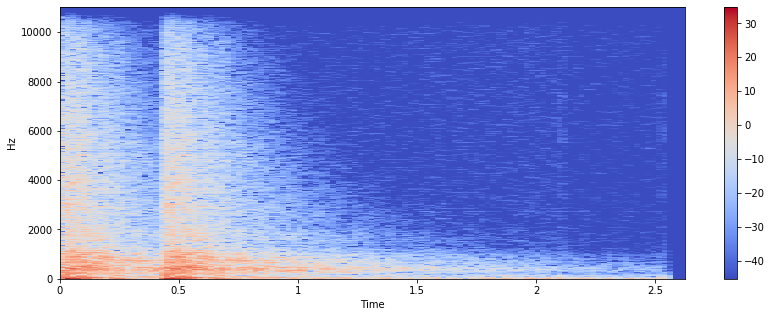

In [4]:
#display Spectrogram
def display_spectrogram(audio):
    X = librosa.stft(audio)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=22050, x_axis='time', y_axis='hz') 
    #If to pring log of frequencies  
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.show()

print("Childen Playing")
sample_wave = data.loc[data['slice_file_name']=='100263-2-0-121.wav']['wave'].apply(display_spectrogram)

print("Gun Shot")
sample_wave = data.loc[data['slice_file_name']=='102305-6-0-0.wav']['wave'].apply(display_spectrogram)



In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(data.mfcc.tolist())
y = np.array(data['class'].tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [6]:
# split the dataset to train, validate and test set

mask = np.random.rand(len(data))
train_mask = mask < 0.7
validation_mask = np.logical_and(mask > 0.7, mask < 0.9)
test_mask = mask > 0.9

x_train = X[train_mask]
x_valid = X[validation_mask]
x_test = X[test_mask]
y_train = yy[train_mask]
y_valid = yy[validation_mask]
y_test = yy[test_mask]

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Dense(256, input_shape=(n_mfcc,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               15616     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime 


checkpointer = ModelCheckpoint(filepath='weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_valid, y_valid), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6088 samples, validate on 1724 samples
Epoch 1/200
5888/6088 [============================>.] - ETA: 0s - loss: 3.0075 - acc: 0.1247
Epoch 00001: val_loss improved from inf to 2.26984, saving model to weights.best.basic_mlp.hdf5
6088/6088 [==============================] - 1s 125us/sample - loss: 2.9832 - acc: 0.1245 - val_loss: 2.2698 - val_acc: 0.1415
Epoch 2/200
5632/6088 [==========================>...] - ETA: 0s - loss: 2.2316 - acc: 0.1605
Epoch 00002: val_loss improved from 2.26984 to 2.21904, saving model to weights.best.basic_mlp.hdf5
6088/6088 [==============================] - 0s 81us/sample - loss: 2.2303 - acc: 0.1613 - val_loss: 2.2190 - val_acc: 0.1531
Epoch 3/200
5952/6088 [============================>.] - ETA: 0s - loss: 2.1562 - acc: 0.2053
Epoch 00003: val_loss improved from 2.21904 to 2.01247, saving model to weights.best.basic_mlp.hdf5
6088/6088 [==============================] - 1s 86us/sample - loss: 2.1530 - acc: 0.2068 - val_loss: 2.0125 - val_acc: 0.

In [11]:

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.97848225
Testing Accuracy:  0.90434784


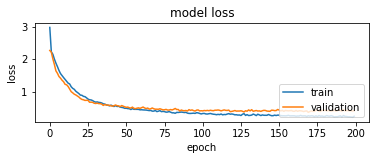

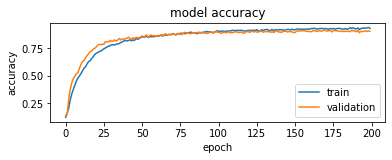

In [12]:
import matplotlib.pyplot as plt
#records = pd.read_csv(modelname + '.csv')
plt.figure()
plt.subplot(211)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
ax = plt.gca()
ax.set_xticklabels([])
plt.subplot(212)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [14]:
predicts = model.predict(x_test, batch_size=2)
predout = np.argmax(predicts, axis=1)
testout = data[test_mask]['classID']
testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=data['class'].unique(),digits=4))

Best accuracy (on testing dataset): 90.43%
                  precision    recall  f1-score   support

        dog_bark     0.8992    0.9907    0.9427       108
children_playing     0.9286    0.8125    0.8667        48
        car_horn     0.8835    0.7712    0.8235       118
 air_conditioner     0.9192    0.8273    0.8708       110
    street_music     0.9515    0.9423    0.9469       104
        gun_shot     0.9263    0.9670    0.9462        91
           siren     0.9512    0.8478    0.8966        46
   engine_idling     0.9684    1.0000    0.9840        92
      jackhammer     0.9722    0.9545    0.9633       110
        drilling     0.7130    0.8817    0.7885        93

        accuracy                         0.9043       920
       macro avg     0.9113    0.8995    0.9029       920
    weighted avg     0.9091    0.9043    0.9044       920



Text(0.5, 23.09375, 'Predicted Label')

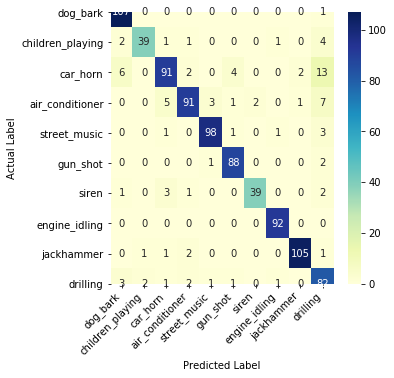

In [15]:
import seaborn as sn
df_cm = pd.DataFrame(confusion, index = data['class'].unique(),
                  columns = data['class'].unique())
plt.figure(figsize=(5,5))
ax=sn.heatmap(df_cm, cmap="YlGnBu", fmt="d", annot=True)
ax.set_xticklabels(
   ax.get_xticklabels(),
   rotation=45,
   horizontalalignment='right'
)
ax.set_ylabel("Actual Label")
ax.set_xlabel("Predicted Label")

With the increase in the number of MFCC bins, we were able to improve the overall model accuracy from 86.30% to 90.40%. An improvement in accuracy by 7.23% with 2.50% increase in total params in the model.

In [16]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, sr=22050, mono=True) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [17]:
def print_prediction(file_name):
    mfcc_feature = extract_features(file_name) 
    prediction_feature = np.array([mfcc_feature])

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(f"{category[0]} \t\t : {format((predicted_proba[i])*100, '.2f')}%")

Mixed audio of children playing and gun shot


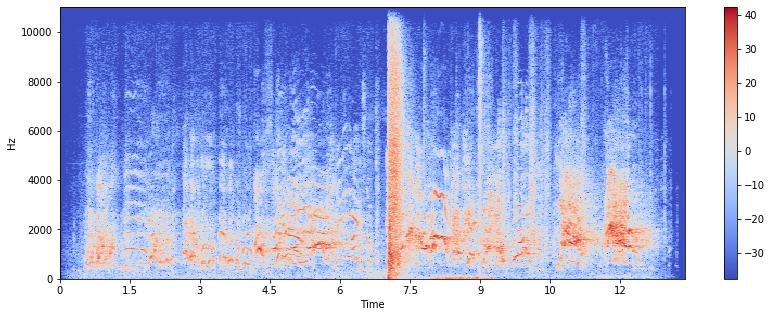

In [18]:
predfile = './testdata/mixedaudio2.wav'
pred_audio, pred_sample_rate = librosa.load(predfile, sr=22050, mono=True) 
print("Mixed audio of children playing and gun shot")
display_spectrogram(pred_audio)

In [19]:
print_prediction(predfile)

The predicted class is: children_playing 

air_conditioner 		 : 0.08%
car_horn 		 : 0.00%
children_playing 		 : 98.15%
dog_bark 		 : 0.52%
drilling 		 : 0.11%
engine_idling 		 : 0.14%
gun_shot 		 : 0.85%
jackhammer 		 : 0.01%
siren 		 : 0.06%
street_music 		 : 0.07%


We observed that the improvement in model accuracy has increase the prediction probability for the children playing class. And the second highest probability is the gun shot sound that we have overlayed on top of children playing.